In this file, I construct the FC as 

1. Get Amat for each segment as U\diag(lambda)U^trans, here lambda is low rank

2. I then do construction of Graph  as 
 
    - transform to correlation 

    - fisher's transform (optinal). I tried both

    - take absolute value or remove the negative value. I tried both

(remove the diaginal term)

Finally, I choose FC as 
- transform to correlation 

- fisher's transform

- take absolute value 

In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN-AD")

In [2]:
import bct

In [3]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
from scipy import signal
from tqdm import tqdm, trange
import pickle
import seaborn as sns
import numbers
import scipy
import pandas as pd
%matplotlib inline

In [4]:
os.chdir("/home/huaqingj/MyResearch/TVDN-AD/")
resDir = Path("./results")
dataDir = Path("./data")

## Some fns

In [5]:
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

def minmax_sysmat(mat):
    """remove diag values and return minmax"""
    trlMask1 = np.tril(np.ones_like(mat), k=-1)
    trlv = mat[trlMask1==1]
    minv, maxv = np.min(trlv), np.max(trlv)
    mat = (mat-minv)/(maxv-minv)
    mat = mat - np.diag(np.diag(mat))
    return mat


In [6]:
def obt_absFC(Ufull, eigVal, is_fisher=True):
    """get abs FC 
        (1) transform to correlation
        
        (2) z transform
        
        (3) take absolute value
        
        (remove the diaginal term)
    """
    n_dim = Ufull.shape[0]
    eigValExt = np.concatenate([eigVal, [0]*(n_dim-len(eigVal))])
    rec_A = Ufull @ np.diag(eigValExt) @ np.linalg.inv(Ufull)
    rec_A = rec_A.real
    FC = np.corrcoef(rec_A) # Pearson's r
    FC = FC - np.diag(np.diag(FC)) # remove diagonal
    if is_fisher:
        FC = np.arctanh(FC) # Fisher's transform
    abs_FC = np.abs(FC)
    return abs_FC

In [7]:
def obt_FC(Ufull, eigVal):
    """get FC 
        (1) transform to correlation
        
        (3) remove negative value 
        
        (remove the diaginal term)
    """
    n_dim = Ufull.shape[0]
    eigValExt = np.concatenate([eigVal, [0]*(n_dim-len(eigVal))])
    rec_A = Ufull @ np.diag(eigValExt) @ np.linalg.inv(Ufull)
    rec_A = rec_A.real
    FC = np.corrcoef(rec_A) # Pearson's r
    FC = FC - np.diag(np.diag(FC)) # remove diagonal
    FC[FC <= 0] = 0
    return FC

In [8]:
def sysMatShuffle(mat):
    mat = mat.copy()
    trlMask1 = np.tril(np.ones_like(mat), k=-1)
    eles = mat[trlMask1==1]
    np.random.shuffle(eles)
    sMat = np.zeros_like(mat)
    sMat[trlMask1==1] = eles
    diag_vs = np.diag(mat)
    np.random.shuffle(diag_vs)
    sMat = sMat + sMat.T + np.diag(diag_vs)
    return sMat

In [9]:
def NetMeasureFn(mat, nrep=50, show_prog=False):
    Cs = bct.clustering_coef_wu(mat)
    mC = np.mean(Cs)
    Ls = bct.distance_wei(mat)[0]
    mL = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
    _, Q = bct.modularity_und(mat)
    
    ranLs = []
    ranQs = []
    ranCs = []
    if show_prog:
        pbar = trange(nrep)
    else:
        pbar = range(nrep)
    for i in pbar:
        sMat = sysMatShuffle(mat)
        Cs = bct.clustering_coef_wu(sMat)
        mCi = np.mean(Cs)
        ranCs.append(mCi)
        Ls = bct.distance_wei(sMat)[0]
        mLi = 1/np.mean(1/Ls[np.eye(Ls.shape[0])!=1])
        ranLs.append(mLi)
        _, Qi = bct.modularity_und(sMat)
        ranQs.append(Qi)
    
    tQ = Q/np.mean(ranQs)
    tmL  = mL/np.mean(ranLs)
    tmC  = mC/np.mean(ranCs)
    return {
        "tmC": tmC, 
        "tmL": tmL, 
        "tQ": tQ, 
        "mC": mC, 
        "mL": mL, 
        "Q": Q, }

In [10]:
# calculat the topk mean of graphic feature based on dwell time
def topk_mean(topk, graphic_f, dwell, key, onlyk=False):
    if onlyk:
        assert len(dwell)>= topk
        idxs = np.array([np.argsort(-dwell)[topk-1]])
    else:
        idxs = np.argsort(-dwell)[:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    sel_dwell = dwell[idxs]
    mean_v = np.mean(sel_graphic_f)
    ws = sel_dwell/np.sum(sel_dwell)
    wmean_v = np.sum(ws*sel_graphic_f)
    return mean_v, wmean_v

In [11]:
# calculat the topk mean of graphic feature based on dwell time after removing top1 dwell 
def exclude_top1_mean(topk, graphic_f, dwell, key):
    assert len(dwell) >= 2
    idxs = np.argsort(-dwell)[1:topk]
    sel_graphic_f = np.array([graphic_f[idx][key] for idx in idxs])
    sel_dwell = dwell[idxs]
    mean_v = np.mean(sel_graphic_f)
    ws = sel_dwell/np.sum(sel_dwell)
    wmean_v = np.sum(ws*sel_graphic_f)
    return mean_v, wmean_v

## Load data

### Save full U (68 x 68)
 (only need run once)

i.e., full eig-vectors

In [30]:
# AD
U_AD_full = []
ps = list(resDir.glob("AD_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for cur_ps in sorted_ps:
    with open(cur_ps, "rb") as f:
        cur_det = pickle.load(f)
    U_AD_full.append(cur_det.midRes.eigVecs)
fil_name = f"AD_data_lamb{cur_det.paras.lamb:.1E}_Ufull.pkl"
with open(resDir/fil_name, "wb") as f:
    pickle.dump(U_AD_full, f)

In [31]:
# ctrl 
U_ctrl_full = []
ps = list(resDir.glob("Ctrl_*04_decimate5.pkl"))
sorted_ps = sorted(ps, key=lambda p:int(p.stem.split("_")[3]))
for cur_ps in tqdm(sorted_ps):
    with open(cur_ps, "rb") as f:
        cur_det = pickle.load(f)
    U_ctrl_full.append(cur_det.midRes.eigVecs)
fil_name = f"Ctrl_data_lamb{cur_det.paras.lamb:.1E}_Ufull.pkl"
with open(resDir/fil_name, "wb") as f:
    pickle.dump(U_ctrl_full, f)

100%|██████████| 92/92 [02:12<00:00,  1.44s/it]


### load all needed results

In [12]:
with open("./OtherFils/KpIdxsAll.pkl", "rb") as sf:
    kpAD, kpCtrl, kpAll = pickle.load(sf)

In [13]:
# ecpts
fil = list(resDir.glob("AD_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_ecpts.pkl"))[0]
with open(fil, "rb") as f:
    ecptssCtrl = pickle.load(f)

In [14]:
# Eigvals
fil = list(resDir.glob("AD_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_eigVals.pkl"))[0]
with open(fil, "rb") as f:
    eigValsCtrl = pickle.load(f)

In [15]:
# full U, i.e., full eig-vectors
fil = list(resDir.glob("AD_*_Ufull.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsFullAD = pickle.load(f)
fil = list(resDir.glob("Ctrl_*_Ufull.pkl"))[0]
with open(fil, "rb") as f:
    eigVecsFullCtrl = pickle.load(f)

In [16]:
# Sel data (only need when use sub data)
ecptssAD = [ ecptsAD for ecptsAD, kpix in zip(ecptssAD, kpAD) if kpix==1]
ecptssCtrl = [ ecptsCtrl for ecptsCtrl, kpix in zip(ecptssCtrl, kpCtrl) if kpix==1]
eigValsAD = [ v for v, kpix in zip(eigValsAD, kpAD) if kpix==1]
eigValsCtrl = [ v for v, kpix in zip(eigValsCtrl, kpCtrl) if kpix==1]
eigVecsFullAD = [ v for v, kpix in zip(eigVecsFullAD, kpAD) if kpix==1]
eigVecsFullCtrl = [ v for v, kpix in zip(eigVecsFullCtrl, kpCtrl) if kpix==1]

In [17]:
# Dwell times in second
freq = 120
dwellsAD = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssAD]
dwellsCtrl = [np.diff(np.concatenate([[0], ecpts, [7200]])/freq) for ecpts in ecptssCtrl]

### Get FC
(remove the diaginal term)

In [19]:
FCs_AD = []
for cur_U, cur_vals in zip(eigVecsFullAD, eigValsAD):
    FC_AD = [obt_FC(cur_U, cur_val) for cur_val in cur_vals]
    FCs_AD.append(FC_AD)

In [23]:
FCs_Ctrl = []
for cur_U, cur_vals in zip(eigVecsFullCtrl, eigValsCtrl):
    FC_Ctrl = [obt_FC(cur_U, cur_val) for cur_val in cur_vals]
    FCs_Ctrl.append(FC_Ctrl)

## Analysis

### Get graphic features

In [24]:
import multiprocessing as mp
def run_fn(ix, FCs):
    print(ix)
    graphic_f = [NetMeasureFn(FC) for FC in FCs]
    #print(ix*100)
    return graphic_f
if __name__ == "__main__":
    with mp.Pool(6) as pool:
        graphic_fs_AD_proc = []
        for ix, FCs in enumerate(FCs_AD):
            graphic_fs_AD_proc.append(pool.apply_async(run_fn, (ix, FCs)))
        graphic_fs_AD = [res.get() for res in graphic_fs_AD_proc]
    pool.join()

0
1
2
3
4
5


/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or n

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [25]:
if __name__ == "__main__":
    with mp.Pool(6) as pool:
        graphic_fs_Ctrl_proc = []
        for ix, FCs in enumerate(FCs_Ctrl):
            graphic_fs_Ctrl_proc.append(pool.apply_async(run_fn, (ix, FCs)))
        graphic_fs_Ctrl = [res.get() for res in graphic_fs_Ctrl_proc]
    pool.join()

3
2
4
5
0
1


/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/huaqingj/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or n

6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [27]:
#By default with fisher transformation
# save it
with open(resDir/"graphic_fs_AD_nofisher_noabs.pkl", "wb") as f:
    pickle.dump(graphic_fs_AD, f)
with open(resDir/"graphic_fs_Ctrl_nofisher_noabs.pkl", "wb") as f:
    pickle.dump(graphic_fs_Ctrl, f)

### load graphic features

In [114]:
# load
#with open(resDir/"graphic_fs_AD_nofisher.pkl", "rb") as f:
#with open(resDir/"graphic_fs_AD_nofisher_noabs.pkl", "rb") as f:
with open(resDir/"graphic_fs_AD.pkl", "rb") as f:
    graphic_fs_AD = pickle.load(f)

#with open(resDir/"graphic_fs_Ctrl_nofisher.pkl", "rb") as f:
#with open(resDir/"graphic_fs_Ctrl_nofisher_noabs.pkl", "rb") as f:
with open(resDir/"graphic_fs_Ctrl.pkl", "rb") as f:
    graphic_fs_Ctrl = pickle.load(f)

###  graphic freatures at the max dwell time 

In [115]:
fs_name = ["Modularity", "Weighted path length", "Clustering coef"]

In [116]:
graphic_fs_AD[0][0].keys()

dict_keys(['tmC', 'tmL', 'tQ', 'mC', 'mL', 'Q'])

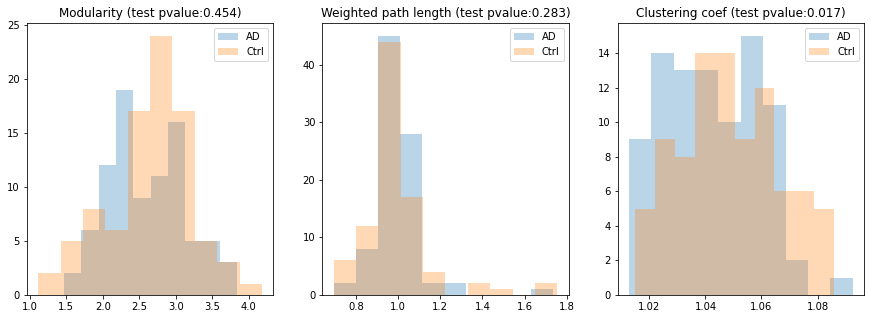

In [121]:
plt.figure(figsize=[15, 5])
for ix, cur_f in enumerate(["tQ", "tmL", "tmC"]):
    cur_fs_AD = [topk_mean(1, graphic_f, dwell, cur_f)[0] 
                 for graphic_f, dwell in zip(graphic_fs_AD, dwellsAD)]
    cur_fs_Ctrl = [topk_mean(1, graphic_f, dwell, cur_f)[0] 
                   for graphic_f, dwell in zip(graphic_fs_Ctrl, dwellsCtrl)]
    #test_res = scipy.stats.ttest_ind(cur_fs_AD, cur_fs_Ctrl, equal_var=False)
    test_res = scipy.stats.ranksums(cur_fs_AD, cur_fs_Ctrl)

    plt.subplot(1, 3, ix+1)
    plt.title(f"{fs_name[ix]} (test pvalue:{test_res.pvalue:.3f})")
    plt.hist(cur_fs_AD, label="AD", alpha=0.3)
    plt.hist(cur_fs_Ctrl, label="Ctrl", alpha=0.3)
    plt.legend()

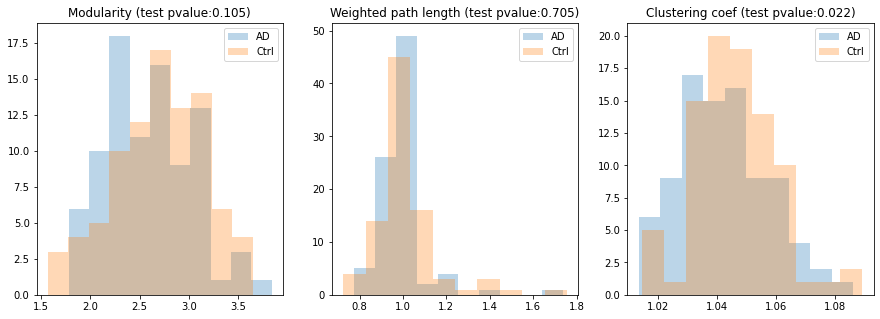

In [122]:
topk = 3
plt.figure(figsize=[15, 5])
for ix, cur_f in enumerate(["tQ", "tmL", "tmC"]):
    cur_fs_AD = [topk_mean(topk, graphic_f, dwell, cur_f)[0] 
                 for graphic_f, dwell in zip(graphic_fs_AD, dwellsAD)]
    cur_fs_Ctrl = [topk_mean(topk, graphic_f, dwell, cur_f)[0] 
                   for graphic_f, dwell in zip(graphic_fs_Ctrl, dwellsCtrl)]
    #test_res = scipy.stats.ttest_ind(cur_fs_AD, cur_fs_Ctrl, equal_var=False)
    test_res = scipy.stats.ranksums(cur_fs_AD, cur_fs_Ctrl)

    plt.subplot(1, 3, ix+1)
    plt.title(f"{fs_name[ix]} (test pvalue:{test_res.pvalue:.3f})")
    plt.hist(cur_fs_AD, label="AD", alpha=0.3)
    plt.hist(cur_fs_Ctrl, label="Ctrl", alpha=0.3)
    plt.legend()

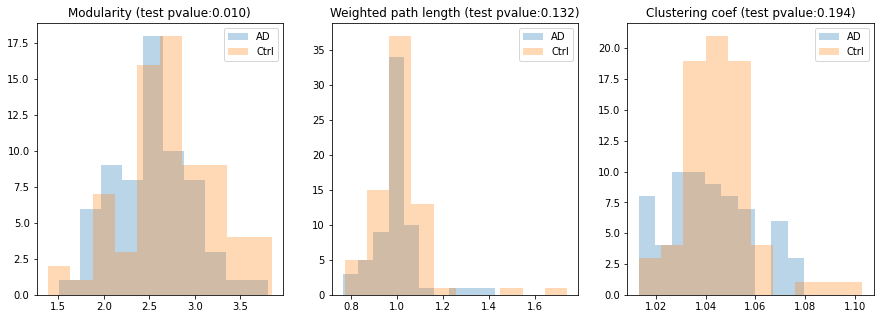

In [123]:
topk = 20
plt.figure(figsize=[15, 5])
for ix, cur_f in enumerate(["tQ", "tmL", "tmC"]):
    cur_fs_AD = [exclude_top1_mean(topk, graphic_f, dwell, cur_f)[0] 
                 for graphic_f, dwell in zip(graphic_fs_AD, dwellsAD) 
                 if len(dwell)>=2]
    cur_fs_Ctrl = [exclude_top1_mean(topk, graphic_f, dwell, cur_f)[0] 
                   for graphic_f, dwell in zip(graphic_fs_Ctrl, dwellsCtrl) 
                   if len(dwell)>= 2]
    #test_res = scipy.stats.ttest_ind(cur_fs_AD, cur_fs_Ctrl, equal_var=False)
    test_res = scipy.stats.ranksums(cur_fs_AD, cur_fs_Ctrl)

    plt.subplot(1, 3, ix+1)
    plt.title(f"{fs_name[ix]} (test pvalue:{test_res.pvalue:.3f})")
    plt.hist(cur_fs_AD, label="AD", alpha=0.3)
    plt.hist(cur_fs_Ctrl, label="Ctrl", alpha=0.3)
    plt.legend()

In [41]:
len(cur_fs_AD)

65